In [1]:
""" Scratch file for testing code related to preprocessing and augmenting data."""

' Scratch file for testing code related to preprocessing and augmenting data.'

In [1]:
import os
import cv2
import numpy as np;
import matplotlib.pyplot as plt
import torch 
import torchvision.transforms as transforms

In [76]:
# img_dir = "small_data_3d/original/train"
# mask_dir = "small_data_3d/ground_truth/train"
img_dir = "small_data_3d_128/original/train"
mask_dir = "small_data_3d_128/ground_truth/train"
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)

In [77]:
# sample image and mask
k = 24
image = np.load(os.path.join(img_dir, img_files[k]))
mask = np.load(os.path.join(mask_dir, mask_files[k]))
depth, height, width = image.shape
print(image.shape, mask.shape)

(5, 128, 128) (5, 128, 128)


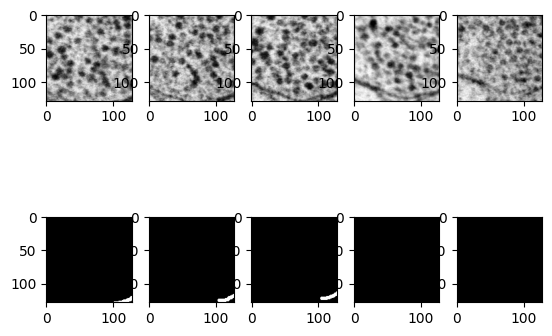

In [78]:
fig, ax = plt.subplots(2, depth)
for i in range(depth):
    ax[0, i].imshow(image[i], cmap="gray")
    ax[1, i].imshow(mask[i], cmap="gray")
plt.show()

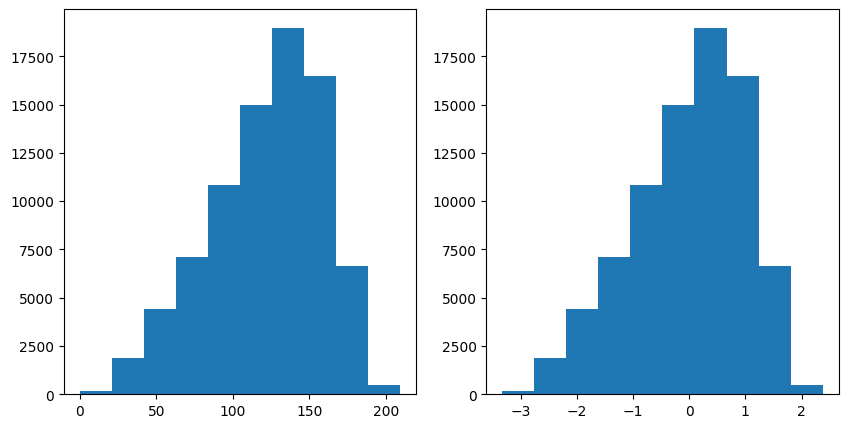

In [79]:
image_preprocessed = (image - image.mean()) / image.std()
image_tensor = torch.tensor(image_preprocessed).float()
image_tensor.dtype
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(image.flatten())
ax[1].hist(image_preprocessed.flatten())
plt.show()

In [80]:
mask_tensor = torch.tensor(mask).float()
print(mask_tensor.shape)
print(mask_tensor.dtype)

torch.Size([5, 128, 128])
torch.float32


In [81]:
torch.nn.functional.one_hot(mask_tensor.long(), num_classes=2).shape

torch.Size([5, 128, 128, 2])

In [89]:
# calculate focal loss
from dataset import SliceDataset
import numpy as np
import os
# Define directories
# x_train_dir="small_data_3d/original/train"
# y_train_dir="small_data_3d/ground_truth/train"
# x_valid_dir="small_data_3d/original/valid"
# y_valid_dir="small_data_3d/ground_truth/valid"
# x_test_dir="small_data_3d/original/test"
# y_test_dir="small_data_3d/ground_truth/test"
data_dir = "small_data_3d_128"
x_train_dir = os.path.join(data_dir, "original/train")
y_train_dir = os.path.join(data_dir, "ground_truth/train")
x_test_dir = os.path.join(data_dir, "original/test")
y_test_dir = os.path.join(data_dir, "ground_truth/test")

model_folder = "models"
sample_preds_folder = "results"

depth, height, width = np.load(os.path.join(x_train_dir, os.listdir(x_train_dir)[0])).shape
# Get train and val dataset instances
train_dataset = SliceDataset(x_train_dir, y_train_dir, image_dim = (width, height), augmentation=None)
valid_dataset = SliceDataset(x_test_dir, y_test_dir, image_dim = (width, height))

In [90]:
from torch.utils.data import DataLoader
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8) # change num_workers as needed
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [91]:
# for i, data in enumerate(valid_loader):
#     inputs, labels = data
#     inputs = inputs[:, :, :300, :300]
#     labels = labels[:,:,  :, :300, :300]
#     print(inputs.shape, labels.shape)
#     break

In [92]:
inputs, labels = valid_dataset[0]
inputs = inputs.unsqueeze(0).unsqueeze(0)
labels = labels.unsqueeze(0)
# dim = 256
# inputs = inputs[:, :, :, :dim, :dim]
# labels = labels[:, :, :,  :dim, :dim]
print(inputs.shape, labels.shape)


torch.Size([1, 1, 5, 128, 128]) torch.Size([1, 2, 5, 128, 128])


# Test Model

In [3]:
import models
import importlib
importlib.reload(models)
from models import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# pred = model(inputs)
# print(pred.shape)

In [4]:
from utilities import *
fp="/Users/huayinluo/Documents/code/gapjncsegmentation/models/tiny/tiny_epoch0.pk1"
model, optimizer, epoch, loss = load_checkpoint(model, optimizer, fp)

In [8]:
epoch

tensor(0.0247, requires_grad=True)

In [5]:
model

UNet(
  (down_conv1): DownBlock(
    (conv_3d): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (double_conv): DoubleConv(
      (conv1): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (down_sample): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (conv_3d): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (double_conv): DoubleConv(
      (conv1): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1,

In [94]:
print(labels.shape)

torch.Size([1, 2, 5, 128, 128])


In [95]:
valid_dataset[0][1].shape

torch.Size([2, 5, 128, 128])

In [ ]:
# # # Initialize loss function
# from tqdm import tqdm
# import torch
# smushed_labels = None
# for i in tqdm(range(len(train_dataset))):
#     if smushed_labels is None: smushed_labels = train_dataset[i][1].to(torch.int64)
#     else: smushed_labels = torch.concat([smushed_labels, train_dataset[i][1].to(torch.int64)])
# class_counts = torch.bincount(smushed_labels.flatten())
# total_samples = len(train_dataset) * 512 * 512
# w1, w2 = 1/(class_counts[0]/total_samples), 1/(class_counts[1]/total_samples)
# cls_weights = torch.Tensor([w1, w2/9])
# print(cls_weights)


In [101]:
import loss
importlib.reload(loss)
from loss import FocalLoss
w1, w2 = 0.2, 0.2
alpha = torch.Tensor([w1, w2/9])
gamma = 3
print(alpha)
criterion = FocalLoss(alpha=cls_weights)

tensor([0.2000, 0.0222])


In [102]:
criterion(pred, labels)

tensor(1.1198, grad_fn=<MeanBackward0>)